# Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Przygotowanie odpowiednich danych

In [2]:
'''
Dla PoC wykonuje obliczenia dla:
 * '../data/DogsCats'
Folder docelowy:
 * '../data/Photos'
'''

dir_path = '../../data/Casia'
A_folder = 'originals'
B_folder = 'photoshops'

In [3]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from keras.preprocessing.image import load_img
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import random

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


# Stałe

In [4]:
# Wilkości

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Przygotowanie Danych

In [5]:
'''
Opis danych:
1 - klasa 1 -> Originals
0 - klasa 2 -> Photoshops
''' 

A_folder_list = os.listdir(dir_path + '/' + A_folder)
B_folder_list = os.listdir(dir_path + '/' + B_folder)

filenames = []
categories = []

for filename in A_folder_list:
    categories.append(0)
    filenames.append(dir_path + '/' + A_folder + '/' + filename)

for filename in B_folder_list:
    categories.append(1)
    filenames.append(dir_path + '/' + B_folder + '/' + filename)


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
# Mieszamy!
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
df.head()

,filename,category
0,../../data/Casia/originals/Au_sec_30147.jpg,0
1,../../data/Casia/photoshops/Tp_S_NRN_S_B_sec20...,1
2,../../data/Casia/originals/Au_nat_30329.jpg,0
3,../../data/Casia/photoshops/Tp_D_NRN_S_N_sec00...,1
4,../../data/Casia/photoshops/Tp_S_CRN_M_N_nat10...,1


In [8]:
df.shape

(12614, 2)

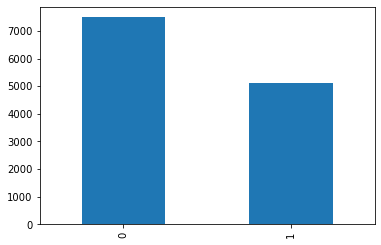

In [9]:
df['category'].value_counts().plot.bar()

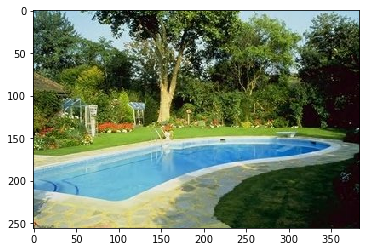

In [10]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)

# Obróbka zdjęć

In [11]:
from skimage.feature import hog
import mahotas
import cv2
from PIL import Image, ImageChops, ImageEnhance
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

def ft_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hu_moments = cv2.HuMoments(cv2.moments(image)).flatten()
    hu_moments = scaler.fit_transform(hu_moments.reshape(-1, 1))
    hu_moments = hu_moments.flatten()
    return hu_moments

def ft_haralick(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(image).mean(axis=0)
    haralick = scaler.fit_transform(haralick.reshape(-1, 1))
    haralick = haralick.flatten()
    return haralick

def ft_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # chanels: [0,1,2], bo mamy przestrzeń HSV
    # mask: None
    # histSize: [8, 8, 8], bin count, po 8 dla każdego z kanałów
    # ranges : [0, 256, 0, 256, 0, 256], wszystko dla każdego z 3 kanałów
    hist  = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def ft_hog(image):
#     image = cv2.resize(image, (64, 64))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features, hog_image = hog(image, block_norm='L2-Hys', pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    return hog_features, hog_image


def ft_ela(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ans = []
    for i in range(86, 96):
        im = Image.fromarray(image)
        im.save(f'tmp_{i}.jpg', 'JPEG', quality=i)
        resaved_im = Image.open(f'tmp_{i}.jpg')

        ela_im = ImageChops.difference(im, resaved_im)

        extrema = ela_im.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        if max_diff == 0:
            max_diff = 1
        scale = 255.0 / max_diff
        ans.append(max_diff)
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    ret = numpy.array([ans]).flatten() / 255

    return ret, ela_im

def preprocess_image(image_path):
    try:
        image = cv2.imread(image_path)
        image = cv2.resize(image, IMAGE_SIZE)
        hu = ft_hu_moments(image)
        haralick = ft_haralick(image)
        histogram = ft_histogram(image)
        ela = ft_ela(image)[0]
        hog = ft_hog(image)[0]
        global_feature = numpy.hstack([hu, haralick, histogram, ela, hog])
        return global_feature
    except Exception as e:
        print(f'Problem with {image_path}, error_msg: {str(e)}')
    

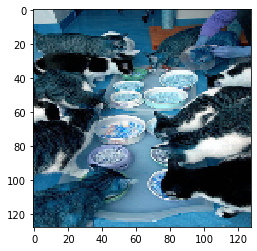

In [12]:
sample = random.choice(df['filename'])
image = cv2.imread(sample)
image = cv2.resize(image, IMAGE_SIZE)
plt.imshow(image)

In [13]:
sample

'../../data/Casia/photoshops/Tp_S_NRN_S_N_ani10207_ani10207_12419.jpg'

Kształt: (10,)
Max: 0.3254901960784314
Min: 0.29411764705882354


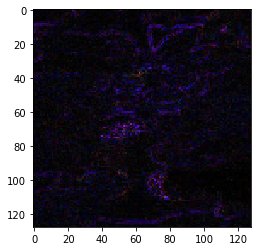

In [14]:
ela = ft_ela(image)

plt.imshow(ela[1])
print(f'Kształt: {ela[0].shape}')
print(f'Max: {numpy.amax(ela[0])}')
print(f'Min: {numpy.amin(ela[0])}')

Kształt: (576,)
Max: 0.5397787652215902
Min: 0.0


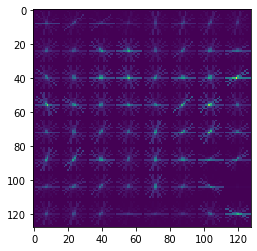

In [15]:
hog_img = ft_hog(image)

plt.imshow(hog_img[1])
print(f'Kształt: {hog_img[0].shape}')
print(f'Max: {numpy.amax(hog_img[0])}')
print(f'Min: {numpy.amin(hog_img[0])}')

In [16]:
histogram = ft_histogram(image)

print(f'Kształt: {histogram.shape}')
print(f'Max: {numpy.amax(histogram)}')
print(f'Min: {numpy.amin(histogram)}')

Kształt: (512,)
Max: 0.2918054163455963
Min: 0.0


In [17]:
hu_moments = ft_hu_moments(image)

print(f'Kształt: {hu_moments.shape}')
print(f'Max: {numpy.amax(hu_moments)}')
print(f'Min: {numpy.amin(hu_moments)}')

Kształt: (7,)
Max: 1.0
Min: 0.0


In [18]:
haralick = ft_haralick(image)

print(f'Kształt: {haralick.shape}')
print(f'Max: {numpy.amax(haralick)}')
print(f'Min: {numpy.amin(haralick)}')

Kształt: (13,)
Max: 1.0
Min: 0.0


In [19]:
print(f'Wielkość całego wektora dla pojedynczego zdjęcia: {hu_moments.shape[0] + haralick.shape[0] + histogram.shape[0] + ela[0].shape[0] + hog_img[0].shape[0]}')
print(f'\t Hu moments({hu_moments.shape[0]}): {(hu_moments.shape[0] * 100)/(hu_moments.shape[0] + haralick.shape[0] + histogram.shape[0] + ela[0].shape[0] + hog_img[0].shape[0]):.2f}%')
print(f'\t Haralick({haralick.shape[0]}): {(haralick.shape[0] * 100)/(hu_moments.shape[0] + haralick.shape[0] + histogram.shape[0] + ela[0].shape[0] + hog_img[0].shape[0]):.2f}%')
print(f'\t Histogram({histogram.shape[0]}): {(histogram.shape[0] * 100)/(hu_moments.shape[0] + haralick.shape[0] + histogram.shape[0] + ela[0].shape[0] + hog_img[0].shape[0]):.2f}%')
print(f'\t Ela({ela[0].shape[0]}): {(ela[0].shape[0] * 100)/(hu_moments.shape[0] + haralick.shape[0] + histogram.shape[0] + ela[0].shape[0] + hog_img[0].shape[0]):.2f}%')
print(f'\t Hog({hog_img[0].shape[0]}): {(hog_img[0].shape[0] * 100)/(hu_moments.shape[0] + haralick.shape[0] + histogram.shape[0] + ela[0].shape[0] + hog_img[0].shape[0]):.2f}%')


Wielkość całego wektora dla pojedynczego zdjęcia: 1118
	 Hu moments(7): 0.63%
	 Haralick(13): 1.16%
	 Histogram(512): 45.80%
	 Ela(10): 0.89%
	 Hog(576): 51.52%


# Przeliczenie Cech Zdjęć + Kategorii

In [20]:
g_f = []
l = []

for i in df['filename']:
    data_img = preprocess_image(i)
    g_f.append(data_img)

for i in df['category']:
    if i == 0:
        l.append('original')
    else:
        l.append('photoshop')

In [21]:
from sklearn.preprocessing import LabelEncoder

print(f'Wektor zdjęć: {numpy.array(g_f).shape}')
print(f'Wektor kategorii słownych: {numpy.array(l).shape}\n')

targetNames = numpy.unique(l)
le = LabelEncoder()
target = le.fit_transform(l)


print(f'Wektor kategorii liczbowych: {target.shape}')
print(f'Max arg: {numpy.argmax(g_f[0])}, Min arg: {numpy.argmin(g_f[0])}')
print(f'Max: {numpy.amax(g_f[0])}, Min: {numpy.amin(g_f[0])}\n')

Wektor zdjęć: (12614, 1118)
Wektor kategorii słownych: (12614,)

Wektor kategorii liczbowych: (12614,)
Max arg: 0, Min arg: 5
Max: 1.0, Min: 0.0



# Zapis/Odczyt

In [22]:
import h5py

def save(features, labels, dataframe, name):
    h5f_data = h5py.File('data_' + str(name) + '.h5', 'w')
    h5f_data.create_dataset('dataset', data=numpy.array(features))

    h5f_label = h5py.File('labels_' + str(name) + '.h5', 'w')
    h5f_label.create_dataset('dataset', data=numpy.array(labels))

    h5f_data.close()
    h5f_label.close()

    dataframe.to_csv('dataframe_' + str(name) + '.csv')
    
def load(features, labels, dataframe):
    h5f_data  = h5py.File(features, 'r')
    h5f_label = h5py.File(labels, 'r')

    global_features_string = h5f_data['dataset']
    global_labels_string   = h5f_label['dataset']

    global_features = numpy.array(global_features_string)
    global_labels   = numpy.array(global_labels_string)

    h5f_data.close()
    h5f_label.close()
    
    df = pd.read_csv(dataframe, index_col = 0)  
    
    return global_features, global_labels, df
    
save(g_f, target, df, name='Casia')

global_features, global_labels, df = load('data_Casia.h5', 'labels_Casia.h5', 'dataframe_Casia.csv')

In [23]:
df.head()

,filename,category
0,../../data/Casia/originals/Au_sec_30147.jpg,0
1,../../data/Casia/photoshops/Tp_S_NRN_S_B_sec20...,1
2,../../data/Casia/originals/Au_nat_30329.jpg,0
3,../../data/Casia/photoshops/Tp_D_NRN_S_N_sec00...,1
4,../../data/Casia/photoshops/Tp_S_CRN_M_N_nat10...,1


In [24]:
print('Kształt po wczytaniu:')
print(f'\tglobal_features: {global_features.shape}')
print(f'\tglobal_labels: {global_labels.shape}')

Kształt po wczytaniu:
	global_features: (12614, 1118)
	global_labels: (12614,)


In [25]:
global_labels[0]

0

In [26]:
from sklearn.decomposition import PCA

n_Casia = 700
n_sCasia = 100

if global_features.shape[0] < 300:
    n_comps = n_sCasia
else:
    n_comps = n_Casia

pca = PCA(n_components=n_comps)
global_features_PCA = pca.fit_transform(global_features)

save(global_features_PCA, target, df, name='Casia_with_PCA')

global_features_PCA, global_labels_PCA, df_PCA = load('data_Casia_with_PCA.h5', 'labels_Casia_with_PCA.h5', 'dataframe_Casia_with_PCA.csv')
del global_features, global_labels, df

In [27]:
print(f'\t Wektor zdjęć: {global_features_PCA.shape}')
print(f'\t Wektor kategorii słownych: {global_labels_PCA.shape}\n')
print(f'\t Wektor dataframe: {df_PCA.shape}')

	 Wektor zdjęć: (12614, 700)
	 Wektor kategorii słownych: (12614,)

	 Wektor dataframe: (12614, 2)


In [28]:
df_PCA.head()

,filename,category
0,../../data/Casia/originals/Au_sec_30147.jpg,0
1,../../data/Casia/photoshops/Tp_S_NRN_S_B_sec20...,1
2,../../data/Casia/originals/Au_nat_30329.jpg,0
3,../../data/Casia/photoshops/Tp_D_NRN_S_N_sec00...,1
4,../../data/Casia/photoshops/Tp_S_CRN_M_N_nat10...,1


# Funkcję liczące statystyki

In [29]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score

def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='binary')
    recall = recall_score(_y_true, _y_pred, average='binary')
    fscore = f1_score(_y_true, _y_pred, average='binary')
    
    return accuracy, precision, recall, fscore

In [31]:
from mlxtend.plotting import plot_confusion_matrix

def plot_cm(cm, classes):
    plot_confusion_matrix(conf_mat=cm,
                          colorbar=True, 
                          show_absolute=True,
                          show_normed=True,
                          class_names=classes)

In [32]:
def statistical_analysis(scores, name, clfs, info=False):
    printmd(f'### Analiza statystyczna dla {name}:')
    
    alfa = .05
    t_statistic = numpy.zeros((len(clfs), len(clfs)))
    p_value = numpy.zeros((len(clfs), len(clfs)))
    
    for i in range(len(clfs)):
        for j in range(len(clfs)):
            t_statistic[i, j], p_value[i, j] = ttest_ind(scores[i], scores[j])
    headers = ["SVM linear", "SVM poly", "SVM rbf", "SVM sigmoid"]
    names_column = numpy.array([["SVM linear"], ["SVM poly"], ["SVM rbf"], ["SVM sigmoid"]])
    t_statistic_table = numpy.concatenate((names_column, t_statistic), axis=1)
    t_statistic_table = tabulate(t_statistic_table, headers, floatfmt=".2f")
    p_value_table = numpy.concatenate((names_column, p_value), axis=1)
    p_value_table = tabulate(p_value_table, headers, floatfmt=".2f")
    
    if info:
        printmd("**t-statistic:**")
        print(t_statistic_table)
        printmd("**p-value:**")
        print(p_value_table)
    
    
    advantage = numpy.zeros((len(clfs), len(clfs)))
    advantage[t_statistic > 0] = 1
    advantage_table = tabulate(numpy.concatenate(
        (names_column, advantage), axis=1), headers)

    if info:
        printmd("**Przewaga:**")
        print(advantage_table)
    
    
    significance = numpy.zeros((len(clfs), len(clfs)))
    significance[p_value <= alfa] = 1
    significance_table = tabulate(numpy.concatenate(
        (names_column, significance), axis=1), headers)
    
    if info:
        printmd("**Różnice statystycznie znaczące (alpha = 0.05):**")
        print(significance_table)
    
    
    stat_better = significance * advantage
    stat_better_table = tabulate(numpy.concatenate(
        (names_column, stat_better), axis=1), headers)
    printmd("**Wynik końcowy analizy statystycznej:**")
    print(stat_better_table)

# Funkcje do liczenia modelu

In [33]:
from sklearn.svm import SVC
from sklearn import clone
import copy
from tabulate import tabulate
from scipy.stats import ttest_ind

def do_the_thing(features, labels, name):
    
    clf_list = {
        "SVM linear": [],
        "SVM poly": [],
        "SVM rbf": [],
        "SVM sigmoid": []
    }
    
    tcm_list = copy.deepcopy(clf_list)
    tAccuracy_list = copy.deepcopy(clf_list)
    tPrecision_list = copy.deepcopy(clf_list)
    tRecall_list = copy.deepcopy(clf_list)
    tFScore_list = copy.deepcopy(clf_list)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=odp)
    clfs = {
        "SVM linear": SVC(kernel='linear', probability=True, random_state=odp, verbose=True, cache_size=1000),
        "SVM poly": SVC(kernel='poly', probability=True, random_state=odp, verbose=True, cache_size=1000),
        "SVM rbf": SVC(kernel='rbf', probability=True, random_state=odp, verbose=True, cache_size=1000),
        "SVM sigmoid": SVC(kernel='sigmoid', probability=True, random_state=odp, verbose=True, cache_size=1000)
    }
    scores_a = numpy.zeros((len(clfs), 5))
    scores_p = numpy.zeros((len(clfs), 5))
    scores_r = numpy.zeros((len(clfs), 5))
    scores_f = numpy.zeros((len(clfs), 5))
    
    for fold_id, (train_index, test_index) in enumerate(kf.split(features, labels)):
        for clf_idx, clf_name in enumerate(clfs):
            clf = clone(clfs[clf_name])
            clf.fit(features[train_index], labels[train_index])
            y_pred = clf.predict(features[test_index])

            accuracy, precision, recall, fscore = countStats(labels[test_index], y_pred)
            cm = confusion_matrix(labels[test_index], y_pred)
            scores_a[clf_idx, fold_id] = accuracy_score(labels[test_index], y_pred, normalize=True)
            scores_p[clf_idx, fold_id] = precision_score(labels[test_index], y_pred, average='binary')
            scores_r[clf_idx, fold_id] = recall_score(labels[test_index], y_pred, average='binary')
            scores_f[clf_idx, fold_id] = f1_score(labels[test_index], y_pred, average='binary')

            tAccuracy_list[clf_name].append(accuracy)
            tPrecision_list[clf_name].append(precision)
            tRecall_list[clf_name].append(recall)
            tFScore_list[clf_name].append(fscore)
            tcm_list[clf_name].append(cm)

    printmd(f'# {name}:')
    print(f'\n\nKształt danych:')
    print(f'\t X_train: {features[train_index].shape}')
    print(f'\t X_test: {features[test_index].shape}')
    print(f'\t y_train: {labels[train_index].shape}')
    print(f'\t y_test: {labels[test_index].shape}')
    
    results = []
    
    for elem in clf_list:
        accuracy_m = numpy.mean(tAccuracy_list[elem])
        precision_m = numpy.mean(tPrecision_list[elem])
        recall_m = numpy.mean(tRecall_list[elem])
        fscore_m = numpy.mean(tFScore_list[elem])
        
        accuracy_std = numpy.std(tAccuracy_list[elem])
        precision_std = numpy.std(tPrecision_list[elem])
        recall_std = numpy.std(tRecall_list[elem])
        fscore_std = numpy.std(tFScore_list[elem])
        
        cm = sum(tcm_list[elem])
        
        res = [str(elem), 
               f'{accuracy_m:.3f} ({accuracy_std:.2f})',
               f'{precision_m:.3f} ({precision_std:.2f})',
               f'{recall_m:.3f} ({recall_std:.2f})',
               f'{fscore_m:.3f} ({fscore_std:.2f})',
               f'{cm}']
        results.append(res)

    printmd(f'### Rezultaty:')
        
    headers = ["Kernel", "Accuracy", "Precision", "Recall", "Fscore", "CM"]
    print('\n')
    print(tabulate(results, headers=headers))
    
    with open(f'{name}_result.txt', 'w') as f:
        print(tabulate(results, headers=headers), file=f)
    
    numpy.save(f'{name}_results_a', scores_a)
    numpy.save(f'{name}_results_p', scores_p)
    numpy.save(f'{name}_results_r', scores_r)
    numpy.save(f'{name}_results_f', scores_f)
    
    statistical_analysis(scores_a, name="Accuracy", clfs=["SVM linear", "SVM poly", "SVM rbf", "SVM sigmoid"])
    statistical_analysis(scores_p, name="Precision", clfs=["SVM linear", "SVM poly", "SVM rbf", "SVM sigmoid"])
    statistical_analysis(scores_r, name="Recall", clfs=["SVM linear", "SVM poly", "SVM rbf", "SVM sigmoid"])
    statistical_analysis(scores_f, name="Fscore", clfs=["SVM linear", "SVM poly", "SVM rbf", "SVM sigmoid"])

# Wynik

In [34]:
do_the_thing(global_features_PCA, global_labels_PCA, name='PCA')

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

# PCA:



Kształt danych:
	 X_train: (10092, 700)
	 X_test: (2522, 700)
	 y_train: (10092,)
	 y_test: (2522,)


### Rezultaty:



Kernel       Accuracy      Precision     Recall        Fscore        CM
-----------  ------------  ------------  ------------  ------------  -------------
SVM linear   0.710 (0.01)  0.664 (0.01)  0.581 (0.01)  0.619 (0.01)  [[5983 1508]
                                                                      [2148 2975]]
SVM poly     0.647 (0.01)  0.618 (0.02)  0.343 (0.01)  0.441 (0.01)  [[6405 1086]
                                                                      [3368 1755]]
SVM rbf      0.725 (0.00)  0.669 (0.00)  0.638 (0.01)  0.653 (0.00)  [[5873 1618]
                                                                      [1857 3266]]
SVM sigmoid  0.662 (0.01)  0.593 (0.01)  0.538 (0.01)  0.564 (0.01)  [[5601 1890]
                                                                      [2369 2754]]


### Analiza statystyczna dla Accuracy:

**Wynik końcowy analizy statystycznej:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           1          0              1
SVM poly                0           0          0              0
SVM rbf                 1           1          0              1
SVM sigmoid             0           1          0              0


### Analiza statystyczna dla Precision:

**Wynik końcowy analizy statystycznej:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           1          0              1
SVM poly                0           0          0              1
SVM rbf                 0           1          0              1
SVM sigmoid             0           0          0              0


### Analiza statystyczna dla Recall:

**Wynik końcowy analizy statystycznej:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           1          0              1
SVM poly                0           0          0              0
SVM rbf                 1           1          0              1
SVM sigmoid             0           1          0              0


### Analiza statystyczna dla Fscore:

**Wynik końcowy analizy statystycznej:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           1          0              1
SVM poly                0           0          0              0
SVM rbf                 1           1          0              1
SVM sigmoid             0           1          0              0
